In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 필요한 만큼만 메모리를 사용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # 특정 GPU에 연산을 할당
        tf.config.set_visible_devices(gpus[0], 'GPU')

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

    except RuntimeError as e:
        print(e)

2024-12-12 19:53:50.285508: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 19:53:50.389418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 19:53:51.210482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1 Physical GPUs, 1 Logical GPU


2024-12-12 19:53:52.858350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12 19:53:53.014727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12 19:53:53.014774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12 19:53:53.018975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-12 19:53:53.019019: I tensorflow/compile

In [ ]:
%cd brain_tumor_mri_dataset/

/home/kimis13/brain_tumor_mri_dataset


In [ ]:
import os
from PIL import Image
from keras.utils import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
train_path=train_df('Training')
test_path=test_df('Testing')

In [ ]:
train_set, valid_set=train_test_split(train_path, test_size=0.2, random_state=42, stratify=train_path['Class'])

In [ ]:
batch_size=32
img_size=(299,299)
_gen=ImageDataGenerator(rescale=1./255,
                        rotation_range=30,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        zoom_range=0.2,
                        fill_mode='nearest',
                        brightness_range=(0.8,1.2))
test_gen=ImageDataGenerator(rescale=1./255)
train_gen=_gen.flow_from_dataframe(train_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
valid_gen=_gen.flow_from_dataframe(valid_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
test_gen=test_gen.flow_from_dataframe(test_path, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=16, shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.


Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
img_shape=(299,299,3)
base_model=tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')
model=Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-5,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='xCeptionV2_best',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
model.compile(optimizer=Adamax(),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [ ]:

train_model=model.fit(train_gen,
                      epochs=15,
                      validation_data=valid_gen,
                      callbacks=callbacks_list,
                      shuffle=False)

Epoch 1/15


2024-12-12 20:57:58.897993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - ETA: 0s - loss: 4.4489 - accuracy: 0.8420 - precision_2: 0.8615 - recall_2: 0.8319

2024-12-12 20:58:53.611158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.79790, saving model to xCeptionV2_best


2024-12-12 20:59:08.256300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 20:59:08.262116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 20:59:10.171183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 20:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 75s 421ms/step - loss: 4.4489 - accuracy: 0.8420 - precision_2: 0.8615 - recall_2: 0.8319 - val_loss: 3.8859 - val_accuracy: 0.7979 - val_precision_2: 0.8065 - val_recall_2: 0.7874 - lr: 0.0010
Epoch 2/15
143/143 [==============================] - ETA: 0s - loss: 2.9342 - accuracy: 0.9280 - precision_2: 0.9337 - recall_2: 0.9212
Epoch 2: val_accuracy improved from 0.79790 to 0.93963, saving model to xCeptionV2_best


2024-12-12 21:00:01.819321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:00:01.825017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:00:03.546556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 54s 375ms/step - loss: 2.9342 - accuracy: 0.9280 - precision_2: 0.9337 - recall_2: 0.9212 - val_loss: 2.4118 - val_accuracy: 0.9396 - val_precision_2: 0.9444 - val_recall_2: 0.9361 - lr: 0.0010
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 1.9881 - accuracy: 0.9589 - precision_2: 0.9632 - recall_2: 0.9562
Epoch 3: val_accuracy did not improve from 0.93963
143/143 [==============================] - 47s 325ms/step - loss: 1.9881 - accuracy: 0.9589 - precision_2: 0.9632 - recall_2: 0.9562 - val_loss: 1.7334 - val_accuracy: 0.9283 - val_precision_2: 0.9332 - val_recall_2: 0.9169 - lr: 0.0010
Epoch 4/15
143/143 [==============================] - ETA: 0s - loss: 1.3825 - accuracy: 0.9597 - precision_2: 0.9641 - recall_2: 0.9589
Epoch 4: val_accuracy improved from 0.93963 to 0.96938, saving model to xCeptionV2_best


2024-12-12 21:01:44.560424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:01:44.566140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:01:45.817600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 56s 372ms/step - loss: 1.3825 - accuracy: 0.9597 - precision_2: 0.9641 - recall_2: 0.9589 - val_loss: 1.1310 - val_accuracy: 0.9694 - val_precision_2: 0.9702 - val_recall_2: 0.9685 - lr: 0.0010
Epoch 5/15
143/143 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.9713 - precision_2: 0.9730 - recall_2: 0.9709
Epoch 5: val_accuracy did not improve from 0.96938
143/143 [==============================] - 45s 315ms/step - loss: 0.9519 - accuracy: 0.9713 - precision_2: 0.9730 - recall_2: 0.9709 - val_loss: 0.8031 - val_accuracy: 0.9676 - val_precision_2: 0.9726 - val_recall_2: 0.9633 - lr: 0.0010
Epoch 6/15
143/143 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.9735 - precision_2: 0.9743 - recall_2: 0.9722
Epoch 6: val_accuracy improved from 0.96938 to 0.97025, saving model to xCeptionV2_best


2024-12-12 21:03:26.220054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:03:26.225677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:03:27.530842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 56s 389ms/step - loss: 0.6825 - accuracy: 0.9735 - precision_2: 0.9743 - recall_2: 0.9722 - val_loss: 0.5945 - val_accuracy: 0.9703 - val_precision_2: 0.9702 - val_recall_2: 0.9676 - lr: 0.0010
Epoch 7/15
143/143 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.9729 - precision_2: 0.9743 - recall_2: 0.9718
Epoch 7: val_accuracy improved from 0.97025 to 0.97638, saving model to xCeptionV2_best


2024-12-12 21:04:19.984386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:04:19.990656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:04:21.314872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 56s 392ms/step - loss: 0.5035 - accuracy: 0.9729 - precision_2: 0.9743 - recall_2: 0.9718 - val_loss: 0.4215 - val_accuracy: 0.9764 - val_precision_2: 0.9772 - val_recall_2: 0.9746 - lr: 0.0010
Epoch 8/15
143/143 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.9801 - precision_2: 0.9811 - recall_2: 0.9794
Epoch 8: val_accuracy did not improve from 0.97638
143/143 [==============================] - 46s 318ms/step - loss: 0.3625 - accuracy: 0.9801 - precision_2: 0.9811 - recall_2: 0.9794 - val_loss: 0.3330 - val_accuracy: 0.9755 - val_precision_2: 0.9764 - val_recall_2: 0.9755 - lr: 0.0010
Epoch 9/15
143/143 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.9814 - precision_2: 0.9820 - recall_2: 0.9805
Epoch 9: val_accuracy improved from 0.97638 to 0.98338, saving model to xCeptionV2_best


2024-12-12 21:06:01.235119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:06:01.240755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:06:02.559622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 53s 368ms/step - loss: 0.2788 - accuracy: 0.9814 - precision_2: 0.9820 - recall_2: 0.9805 - val_loss: 0.2458 - val_accuracy: 0.9834 - val_precision_2: 0.9842 - val_recall_2: 0.9834 - lr: 0.0010
Epoch 10/15
143/143 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9831 - precision_2: 0.9840 - recall_2: 0.9823
Epoch 10: val_accuracy did not improve from 0.98338
143/143 [==============================] - 48s 336ms/step - loss: 0.2182 - accuracy: 0.9831 - precision_2: 0.9840 - recall_2: 0.9823 - val_loss: 0.2403 - val_accuracy: 0.9676 - val_precision_2: 0.9701 - val_recall_2: 0.9668 - lr: 0.0010
Epoch 11/15
143/143 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9821 - precision_2: 0.9829 - recall_2: 0.9814
Epoch 11: val_accuracy did not improve from 0.98338
143/143 [==============================] - 45s 315ms/step - loss: 0.1849 - accuracy: 0.9821 - precision_2: 0.9829 - recall_2: 0.9814 - val_loss: 0

2024-12-12 21:09:17.100313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:09:17.105629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-12-12 21:09:18.419342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2024-12-12 21:

INFO:tensorflow:Assets written to: xCeptionV2_best/assets


INFO:tensorflow:Assets written to: xCeptionV2_best/assets


143/143 [==============================] - 56s 394ms/step - loss: 0.1277 - accuracy: 0.9842 - precision_2: 0.9851 - recall_2: 0.9840 - val_loss: 0.1179 - val_accuracy: 0.9869 - val_precision_2: 0.9877 - val_recall_2: 0.9860 - lr: 0.0010
Epoch 14/15
143/143 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9888 - precision_2: 0.9888 - recall_2: 0.9886
Epoch 14: val_accuracy did not improve from 0.98688
143/143 [==============================] - 45s 311ms/step - loss: 0.0973 - accuracy: 0.9888 - precision_2: 0.9888 - recall_2: 0.9886 - val_loss: 0.1442 - val_accuracy: 0.9816 - val_precision_2: 0.9842 - val_recall_2: 0.9816 - lr: 0.0010
Epoch 15/15
143/143 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9897 - precision_2: 0.9899 - recall_2: 0.9895
Epoch 15: val_accuracy did not improve from 0.98688
143/143 [==============================] - 48s 337ms/step - loss: 0.0840 - accuracy: 0.9897 - precision_2: 0.9899 - recall_2: 0.9895 - val_loss: 0

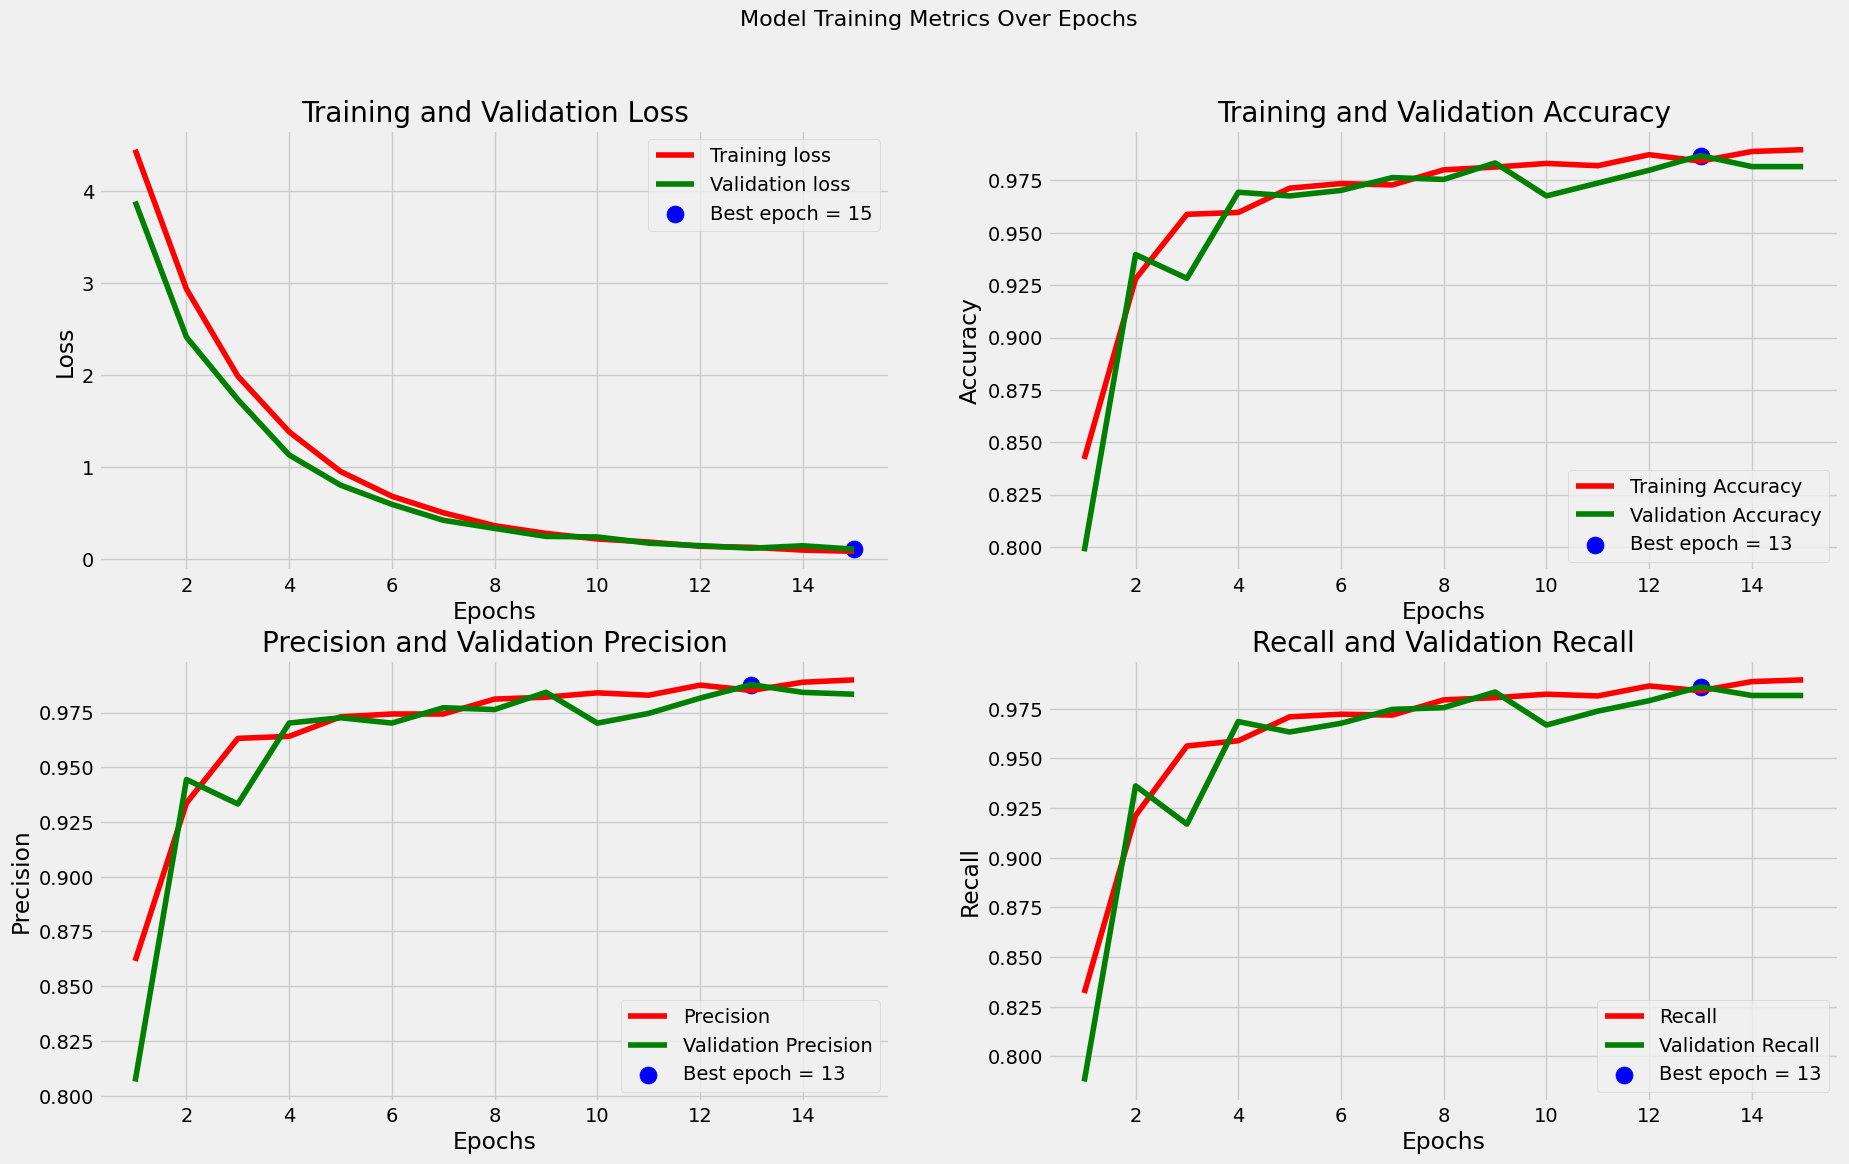

In [ ]:
tr_acc = train_model.history['accuracy']
tr_loss = train_model.history['loss']
tr_per = train_model.history['precision_2']
tr_recall = train_model.history['recall_2']
val_acc = train_model.history['val_accuracy']
val_loss = train_model.history['val_loss']
val_per = train_model.history['val_precision_2']
val_recall = train_model.history['val_recall_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

2024-12-12 21:17:22.434355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 36s 251ms/step - loss: 0.0814 - accuracy: 0.9904 - precision_2: 0.9904 - recall_2: 0.9895


2024-12-12 21:17:58.817951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - 9s 231ms/step - loss: 0.1259 - accuracy: 0.9773 - precision_2: 0.9772 - recall_2: 0.9755


2024-12-12 21:18:07.383812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 3s 31ms/step - loss: 0.0823 - accuracy: 0.9878 - precision_2: 0.9878 - recall_2: 0.9878
Train Loss: 0.0814
Train Accuracy: 99.04%
--------------------
Validation Loss: 0.1259
Validation Accuracy: 97.73%
--------------------
Test Loss: 0.0823
Test Accuracy: 98.78%


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

2024-12-12 21:20:01.129971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 3s 30ms/step


In [ ]:
classes=test_gen.class_indices
classes

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

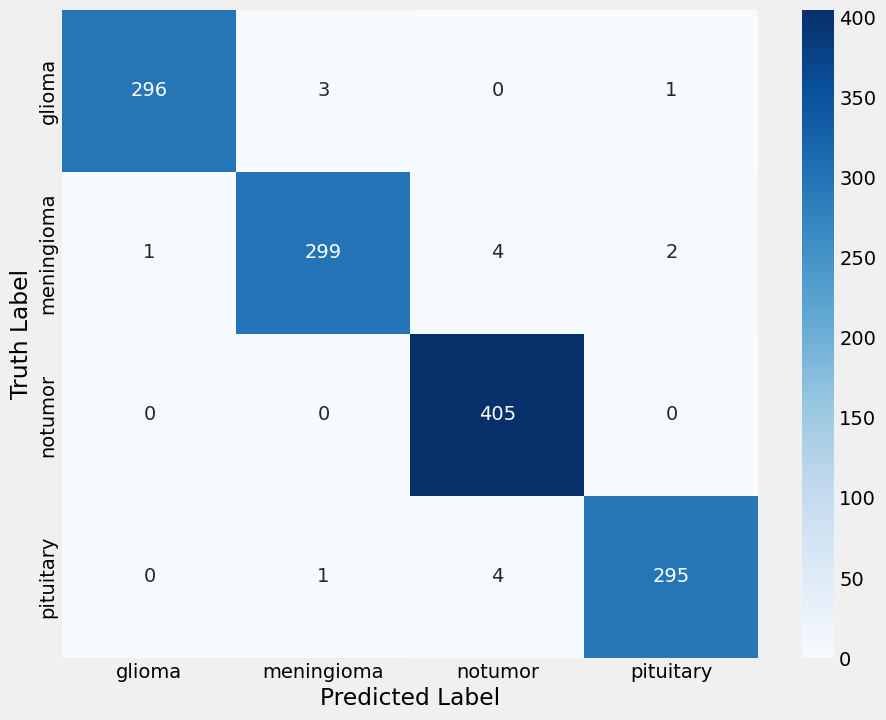

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(classes.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()